# Passband and Baseband Equivalent Signals

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

from IPython.display import Audio

In [2]:
# load functions from the tool box
from comms.mod_mapping import mod_mapper, QPSK, demodulator, plot_constellation
from comms.sources import string_sink, string_source
from comms.pulse_shaping import pulse_shape, srrc_pulse

### Waveform Design

**Goal:** Design a passband communication system with the following specifications:

* Symbol Rate: 480 symbols per second
* Modulation: QPSK
* Pulse-shaping: SRRC filter with excess bandwidth 30%
* Carrier frequency: 3KHz

The message to be transmitted is the string `All Together Different`

In [3]:
## Parameters
R = 480    # symbol rate
mod_table = QPSK

a = 0.3       # excess bandwidth
N_trunc = 10  # truncate the SRRC pulse

fc = 3000    # carrier frequency

# sample rate
fs = 48000 # sample rate (a standard audio rate)
fsT = fs // R

# pulse shape
pp = srrc_pulse(a, fsT, N_trunc)

### Transmitter

The transmitter performs

* encoding of message to bits
* mapping bits to symbols
* pulse-shaping
* upconversion using a quadrature mixer
  - Quadrature mixer is implemented as
  $$
  s_p(t) = \Re\{m(t) \cdot e^{j2\pi f_c t}\}
  $$
  - We could have used
  $$
  s_p(t) = \Re\{m(t)\} \cdot \cos(2\pi f_c t) - \Im\{m(t)\} \cdot \sin(2\pi f_c t)
  $$
  instead.

In [4]:
## Transmitter
msg = 'ECE 460 is my favourite class!'
bits = string_source(msg)
syms = mod_mapper(bits, mod_table)

# baseband signal
bb_sig = pulse_shape(syms, pp, fsT)

# upconversion
tt = np.arange(len(bb_sig))/fs
pb_sig = np.real(bb_sig * np.exp(2j*np.pi * fc * tt) ) # quadrature mixer

### Spectrum of the transmitted signal

* The plot below shows the power spectral density (PSD) of the passband and baseband signals
  - PSD is computed using `plt.psd`
* The passband signal is shifted in frequency to $\pm f_c$
* Magnitude is half of baseband signal
  - 3dB lower

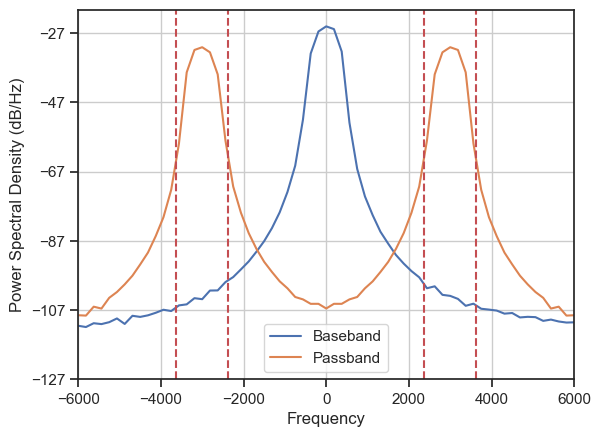

In [5]:
# plot the spectrum of the transmitted signal
plt.psd(bb_sig, Fs=fs, sides='twosided', label='Baseband')
plt.psd(pb_sig, Fs=fs, sides='twosided', label='Passband')

plt.axvline(fc+(1+a)*R, color='r', ls='--')
plt.axvline(fc-(1+a)*R, color='r', ls='--')
plt.axvline(-fc+(1+a)*R, color='r', ls='--')
plt.axvline(-fc-(1+a)*R, color='r', ls='--')

plt.xlim(-2*fc, 2*fc)
plt.legend()


plt.show()

### Time Domain

* The plot below shows a short segment of the signals in the time-domain
  - the passband signal and
  - the absolute value of the baseband signal are plotted
* Note that the passband signal oscillates between the absolute value of the baseband signal and it's negative.
  - *complex envelope*

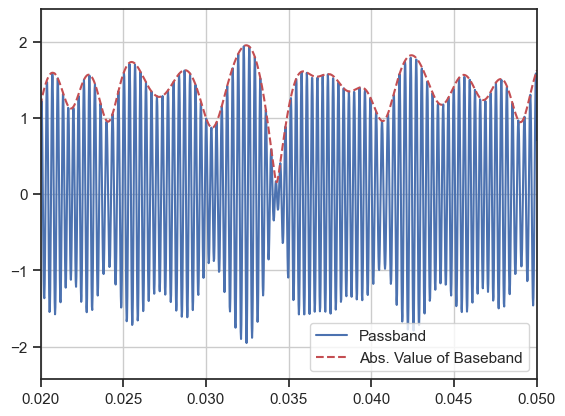

In [6]:
plt.plot(tt, pb_sig, label="Passband")
plt.plot(tt, np.abs(bb_sig), 'r--', label='Abs. Value of Baseband')

plt.grid()
plt.xlim(0.02, 0.05)

plt.legend()

plt.show()

Audio(pb_sig, rate=fs)


# Channel

The channel adds Gaussian noise to the transmitted signal. The noise power is such that the signal-to-noise ratio is approximately 30dB.

In [7]:
# channel
n_pwr = fsT/R # no noise to see if there is any ISI      # fsT/100  # 20dB SNR
rx_pb_sig = pb_sig + np.sqrt(n_pwr) * np.random.randn(len(pb_sig))

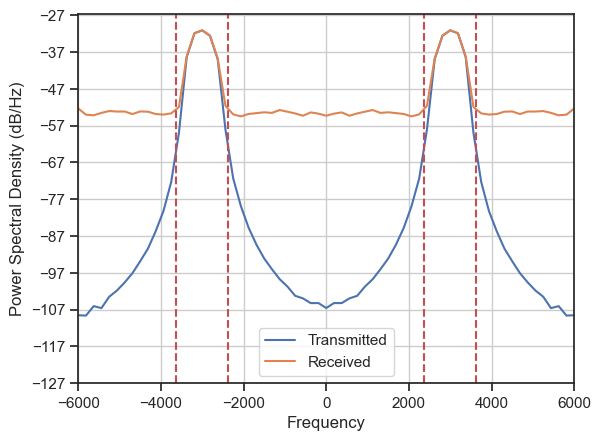

In [8]:
# plot the spectrum of the transmitted signal
# plt.psd(bb_sig, Fs=fs, sides='twosided', label='Baseband')
plt.psd(pb_sig, Fs=fs, sides='twosided', label='Transmitted')
plt.psd(rx_pb_sig, Fs=fs, sides='twosided', label='Received')

plt.axvline(fc+(1+a)*R, color='r', ls='--')
plt.axvline(fc-(1+a)*R, color='r', ls='--')
plt.axvline(-fc+(1+a)*R, color='r', ls='--')
plt.axvline(-fc-(1+a)*R, color='r', ls='--')

plt.xlim(-2*fc, 2*fc)
plt.legend()

plt.show()

### Time Domain

In the time-domain, the noise is clearly visible.
* the baseband transmitted signal is no longer an envelope

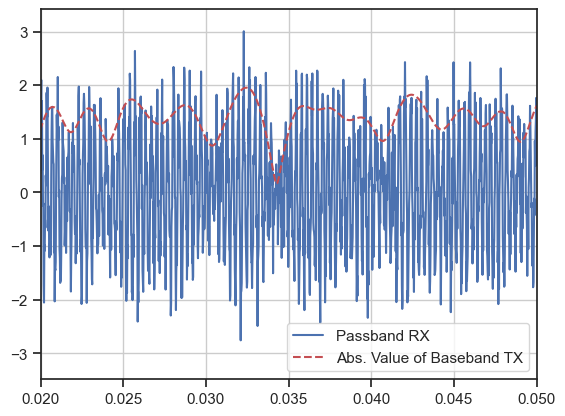

In [9]:
plt.plot(tt, rx_pb_sig, label="Passband RX")
plt.plot(tt, np.abs(bb_sig), 'r--', label='Abs. Value of Baseband TX')

plt.grid()
plt.xlim(0.02, 0.05)

plt.legend()

plt.show()

Audio(rx_pb_sig, rate=fs)


## Receiver

The receiver performs:
* down-conversion using a quadrature mixer
* matched filtering
* demodulation
* decoding of received bits into message

In [10]:
## Receiver
# down-conversion - we omit the LPF as the matched filter is a low-pass filter
tt = np.arange(len(rx_pb_sig)) / fs
rx_bb_sig = rx_pb_sig * 2*np.exp(-2j*np.pi * fc * tt)  # quadrature mixer

# matched filter and down-sampling
mf_out = np.convolve(rx_bb_sig, pp)/fsT
rx_syms = mf_out[2*N_trunc*fsT:-2*N_trunc*fsT:fsT]

# demodulate and decode
rx_bits = demodulator(rx_syms, mod_table)
print('Received message:', string_sink(rx_bits))

Received message: ECE 460 is my favourite class!


### Spectra

The plot below shows the PSD of
* received passband signal $r_p(t)$ (real-valued)
* the down-converted signal $r_p(t) \cdot e^{-j2\pi f_c t}$
* the matched filter output

Note that the matched filter removes nearly all noise - except noise that's in the frequency band of the signal.

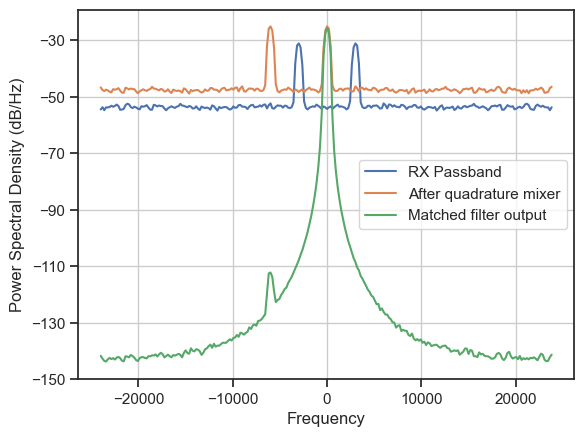

In [11]:
plt.psd(rx_pb_sig, Fs=fs, sides='twosided', label='RX Passband')
plt.psd(rx_bb_sig, Fs=fs, sides='twosided', label='After quadrature mixer')
plt.psd(mf_out, Fs=fs, sides='twosided', label='Matched filter output')

plt.legend()

plt.show()

### Time domain

The plot below shows the real and imaginary parts of the matched filter output.
* transients from pulse-shaping are visible on both ends of the signal
* both signals "cluster" near $\pm 1$
  - recall that QPSK symbols are of the form $\pm 1 \pm j$

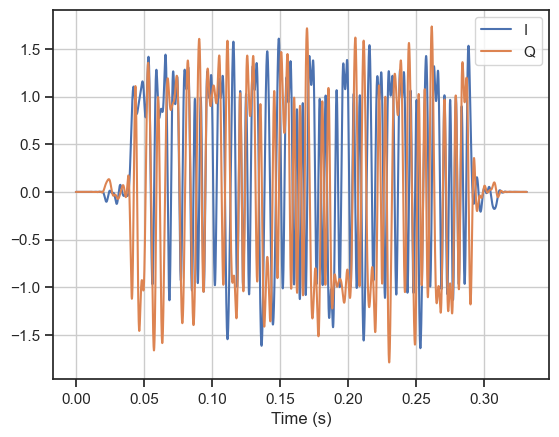

In [12]:
tt = np.arange(len(mf_out))/fs
plt.plot(tt, np.real(mf_out), label='I')
plt.plot(tt, np.imag(mf_out), label='Q')
plt.grid()

plt.xlabel('Time (s)')
plt.legend()

plt.show()


### Received symbols

The sampled matched filter outputs are shown below:
* the red circles indicated the symbol locations in the QPSK constellation
* Each blue dot represents one sample of the matched filter output

The matched filter outputs are clustered tightly around the symbol locations
* displacements are due to noise
* there are no apparent symbol errors - well, the message was received correctly

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


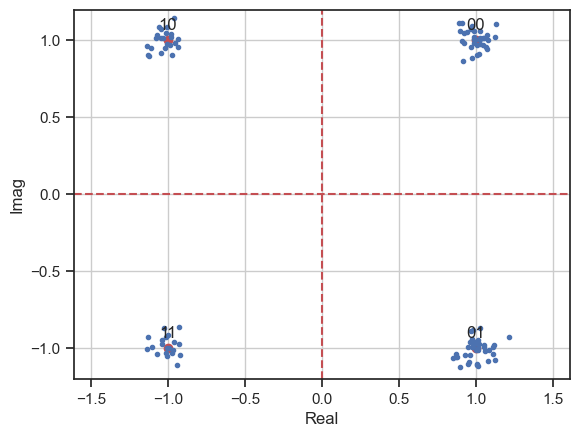

In [13]:

plot_constellation(mod_table)
plt.plot(np.real(rx_syms), np.imag(rx_syms), '.')

plt.axvline(0, color='r', ls='--')
plt.axhline(0, color='r', ls='--')

plt.show()

## Phase and frequency error

**Question:** What happens if the transmitter and receiver are not perfectly synchronized?
* identical carrier frequency 
* identical carrier phase

In [14]:
## down-convert with phase or frequency error
d_phase = np.pi/5   # phase error
d_freq = 0            # frequency error

# down-conversion - with error
tt = np.arange(len(rx_pb_sig)) / fs
rx_bb_sig = rx_pb_sig * 2*np.exp(-1j*(2*np.pi * (fc + d_freq) * tt + d_phase) )  # quadrature mixer

# matched filter and down-sampling
mf_out = np.convolve(rx_bb_sig, pp)/fsT
rx_syms = mf_out[2*N_trunc*fsT:-2*N_trunc*fsT:fsT]

# demodulate and decode
rx_bits = demodulator(rx_syms, mod_table)
print('Received message:', string_sink(rx_bits))



Received message: ECE 460 is my favourite class!


### Received Symbol with phase error

The plot below shows the sampled matched filter outputs:
* received symbols (blue dots) are rotated by the negative of the phase error
* this causes a lot of errors if the phase error is greater than approximately $\pi/4$

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


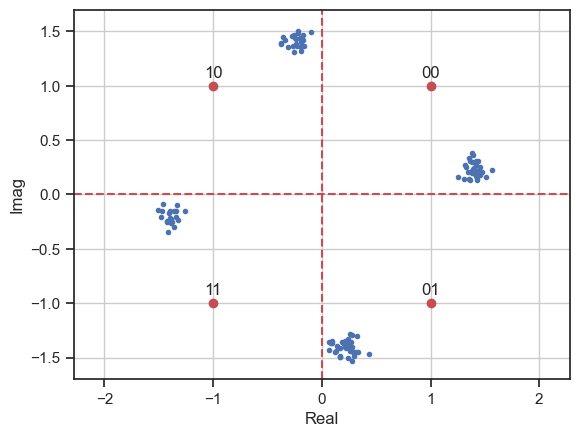

In [15]:
plot_constellation(mod_table)
plt.plot(np.real(rx_syms), np.imag(rx_syms), '.')

plt.xlim(-1.7,1.7)
plt.ylim(-1.7, 1.7)

plt.axvline(0, color='r', ls='--')
plt.axhline(0, color='r', ls='--')

plt.show()

In [16]:
## down-convert with phase or frequency error
d_phase = 0   # phase error
d_freq = 1    # frequency error 3001 instead of 3000

# down-conversion - with error
tt = np.arange(len(rx_pb_sig)) / fs
rx_bb_sig = rx_pb_sig * 2*np.exp(-1j*(2*np.pi * (fc + d_freq) * tt + d_phase) )  # quadrature mixer

# matched filter and down-sampling
mf_out = np.convolve(rx_bb_sig, pp)/fsT
rx_syms = mf_out[2*N_trunc*fsT:-2*N_trunc*fsT:fsT]

# demodulate and decode
rx_bits = demodulator(rx_syms, mod_table)
print('Received message:', string_sink(rx_bits))

Received message: ECE 460 is iaE���������E�����G


### Received symbols with frequency error

Frequency error is represents a slowly but steadily increasing phase error;
* the first few symbols are decoded correctly
* then, all decoded symbols are wrong


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


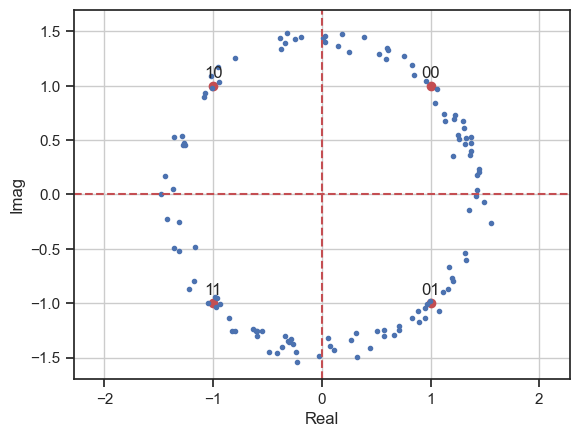

In [17]:
plot_constellation(mod_table)
plt.plot(np.real(rx_syms), np.imag(rx_syms), '.')

plt.xlim(-1.7,1.7)
plt.ylim(-1.7, 1.7)

plt.axvline(0, color='r', ls='--')
plt.axhline(0, color='r', ls='--')

plt.show()

### Insights

The transmitter and receiver must be synchronized very accurately in phase and frequency.

In a receiver implementation, this is accomplished by two means:
* usually, the transmitted contains a brief, known training signal that allows the transmitter to synchronize initially
* while symbols are received, differences between received symbols and constellation points are used to drive a feedback control loop that adjust the transmitter phase and frequency constantly.

Synchronization is not covered in ECE 460; it is a topic for ECE 463.